In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from sympy import *
from sympy.physics.quantum.dagger import Dagger

In [2]:
def trace(M):
    return M[0,0] + M[1,1] + M[2,2] + M[3,3]

In [3]:
t,p,ta,pa = symbols('theta phi theta_a phi_a', real=True)

In [73]:
GA = Matrix([[cos(p/2)**2, I*cos(p/2)*sin(p/2), cos(p/2), 0],[-I*cos(p/2)*sin(p/2), sin(p/2)**2, -I*sin(p/2),0],
            [cos(p/2),I*sin(p/2),1,0],[0,0,0,0]])
GB = Matrix([[cos(p/2)**2, I*cos(p/2)*sin(p/2), 0, 0],[-I*cos(p/2)*sin(p/2), sin(p/2)**2, 0,0],
            [0,0,1,0],[0,0,0,0]])
AP = Matrix([[cos(ta/2),0,sin(ta/2),0],[0,cos(ta/2),0,sin(ta/2)],[sin(ta/2),0,-cos(ta/2),0],
              [0,sin(ta/2),0,-cos(ta/2)]])
AR = Matrix([[cos(pa/2),I*sin(pa/2),0,0],[I*sin(pa/2),cos(pa/2),0,0],[0,0,cos(pa/2),I*sin(pa/2)],
             [0,0,I*sin(pa/2),cos(pa/2)]])
AR_PS = Matrix([[cos(pa/2),I*sin(pa/2),0,0],[I*sin(pa/2),cos(pa/2),0,0],[0,0,1,0],
             [0,0,0,1]]) 
GoutA = conjugate(AR)*conjugate(AP)*GA*AP.T*AR.T
GoutB = conjugate(AR)*conjugate(AP)*GB*AP.T*AR.T

In [75]:
trigsimp(GoutA-GoutB)

Matrix([
[                                                 2*sin(theta_a/2)*cos(phi_a/2)*cos(theta_a/2)*cos((phi + phi_a)/2),                                                  I*(cos(phi/2 + phi_a - theta_a) - cos(phi/2 + phi_a + theta_a))/4, -cos(phi/2 - theta_a)/4 - cos(phi/2 + theta_a)/4 - cos(phi/2 + phi_a - theta_a)/4 - cos(phi/2 + phi_a + theta_a)/4,                                   I*(2*sin(phi/2) - sin(phi/2 + phi_a - theta_a) - sin(phi/2 + phi_a + theta_a))/4],
[                                                I*(-cos(phi/2 + phi_a - theta_a) + cos(phi/2 + phi_a + theta_a))/4,                                                  2*sin(phi_a/2)*sin(theta_a/2)*sin((phi + phi_a)/2)*cos(theta_a/2),                                   I*(2*sin(phi/2) + sin(phi/2 + phi_a - theta_a) + sin(phi/2 + phi_a + theta_a))/4, -cos(phi/2 - theta_a)/4 - cos(phi/2 + theta_a)/4 + cos(phi/2 + phi_a - theta_a)/4 + cos(phi/2 + phi_a + theta_a)/4],
[-cos(phi/2 - theta_a)/4 - cos(phi/2 + theta_a)/4 - cos(phi

In [47]:
G

Matrix([
[           cos(phi/2)**2, I*sin(phi/2)*cos(phi/2),    cos(phi/2), 0],
[-I*sin(phi/2)*cos(phi/2),           sin(phi/2)**2, -I*sin(phi/2), 0],
[              cos(phi/2),            I*sin(phi/2),             1, 0],
[                       0,                       0,             0, 0]])

In [71]:
C_ta_pa = trigsimp((Gout[0,0]-Gout[1,1]-Gout[2,2]+Gout[3,3])/(Gout[0,0]+Gout[1,1]+Gout[2,2]+Gout[3,3]))
C_ta_pa

(-cos(phi_a) + cos(phi + phi_a))*cos(theta_a)/2

In [66]:
Expected = sin(p/2)*sin(ta-pa-p/2) - (1-sin(p/2))*cos(pa+p/2)*sin(ta)
trigsimp(Expected-C_ta_pa)

sin(phi/2 + phi_a - theta_a) - sin(phi/2 + phi_a + theta_a) - cos(phi_a - theta_a)/2 + cos(phi_a + theta_a)/2 + cos(phi + phi_a - theta_a)/2 - cos(phi + phi_a + theta_a)/2

(0.0, 6.283185307179586, 0.0, 6.283185307179586)

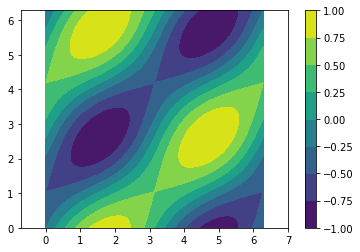

In [68]:
f = lambdify((t,p,ta,pa),trigsimp(C_ta_pa), "numpy")
ta_range = np.linspace(0,2*np.pi,1000)
pa_range = np.linspace(0,2*np.pi,1000)
phi_fixed = np.pi/3
X, Y = np.meshgrid(ta_range, pa_range)
def ftemp(ta_val,pa_val):
    return f(0,phi_fixed,ta_val,pa_val)
Z = ftemp(X,Y)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)
ax.axis('equal')

In [62]:
G_input = Matrix([1,0,1,0])*Matrix([1,0,1,0]).T
a = conjugate(AR_PS)*G_input*AR_PS.T

In [63]:
a

Matrix([
[             cos(phi_a/2)**2, I*sin(phi_a/2)*cos(phi_a/2),    cos(phi_a/2), 0],
[-I*sin(phi_a/2)*cos(phi_a/2),             sin(phi_a/2)**2, -I*sin(phi_a/2), 0],
[                cos(phi_a/2),              I*sin(phi_a/2),               1, 0],
[                           0,                           0,               0, 0]])

In [15]:
trigsimp(trace(a*a) - 1)*1/3

(1 - cos(phi_a))**2/6 + cos(phi_a)/3 - cos(2*phi_a)/12 + 3/4